In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import tensorflow as tf
import tensorflow_decision_forests as tfdf

2024-11-13 04:56:35.727800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 04:56:35.731022: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 04:56:35.739303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731448595.753737  106011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731448595.757303  106011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 04:56:35.773493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
!curl -L -o faktor-stunting.zip\
https://www.kaggle.com/api/v1/datasets/download/harnelia/faktor-stunting

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 45433  100 45433    0     0  22029      0  0:00:02  0:00:02 --:--:--  107k


In [3]:
!unzip faktor-stunting.zip

Archive:  faktor-stunting.zip
  inflating: Stunting_Dataset.csv    


In [44]:
# Load the dataset
df = pd.read_csv('Stunting_Dataset.csv')
df

,Gender,Age,Birth Weight,Birth Length,Body Weight,Body Length,Breastfeeding,Stunting
0,Male,17,3.0,49,10.0,72.2,No,No
1,Female,11,2.9,49,2.9,65.0,No,Yes
2,Male,16,2.9,49,8.5,72.2,No,Yes
3,Male,31,2.8,49,6.4,63.0,No,Yes
4,Male,15,3.1,49,10.5,49.0,No,Yes
...,...,...,...,...,...,...,...,...
9995,Male,15,3.0,49,9.0,63.0,No,Yes
9996,Female,12,2.8,48,7.7,63.0,No,No
9997,Male,16,2.8,49,7.7,49.0,No,No
9998,Male,14,2.8,49,10.0,69.0,No,Yes


In [45]:
df = df.drop(columns=['Breastfeeding'])

In [46]:
df = df.rename(columns={
    'Birth Weight': 'Birth_Weight',
    'Birth Length': 'Birth_Length',
    'Body Weight': 'Body_Weight',
    'Body Length': 'Body_Length'
})

In [47]:
# 1. BMI Bayi
df['BMI'] = df['Body_Weight'] / (df['Body_Length'] ** 2)

# 2. Perbedaan Berat dari saat Lahir hingga Sekarang
df['Weight_Diff'] = df['Body_Weight'] - df['Birth_Weight']

# 3. Perbedaan Panjang dari saat Lahir hingga Sekarang
df['Length_Diff'] = df['Body_Length'] - df['Birth_Length']

# Menampilkan data dengan fitur baru
print(df.head())

   Gender  Age  Birth_Weight  Birth_Length  Body_Weight  Body_Length Stunting  \
0    Male   17           3.0            49         10.0         72.2       No   
1  Female   11           2.9            49          2.9         65.0      Yes   
2    Male   16           2.9            49          8.5         72.2      Yes   
3    Male   31           2.8            49          6.4         63.0      Yes   
4    Male   15           3.1            49         10.5         49.0      Yes   

        BMI  Weight_Diff  Length_Diff  
0  0.001918          7.0         23.2  
1  0.000686          0.0         16.0  
2  0.001631          5.6         23.2  
3  0.001612          3.6         14.0  
4  0.004373          7.4          0.0  


In [48]:
print(df.shape)  # ukuran dataset
print(df.info()) # informasi tipe data
print(df.head()) # beberapa baris pertama

(10000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        10000 non-null  object 
 1   Age           10000 non-null  int64  
 2   Birth_Weight  10000 non-null  float64
 3   Birth_Length  10000 non-null  int64  
 4   Body_Weight   10000 non-null  float64
 5   Body_Length   10000 non-null  float64
 6   Stunting      10000 non-null  object 
 7   BMI           10000 non-null  float64
 8   Weight_Diff   10000 non-null  float64
 9   Length_Diff   10000 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 781.4+ KB
None
   Gender  Age  Birth_Weight  Birth_Length  Body_Weight  Body_Length Stunting  \
0    Male   17           3.0            49         10.0         72.2       No   
1  Female   11           2.9            49          2.9         65.0      Yes   
2    Male   16           2.9            49          

Gender          0
Age             0
Birth_Weight    0
Birth_Length    0
Body_Weight     0
Body_Length     0
Stunting        0
BMI             0
Weight_Diff     0
Length_Diff     0
dtype: int64


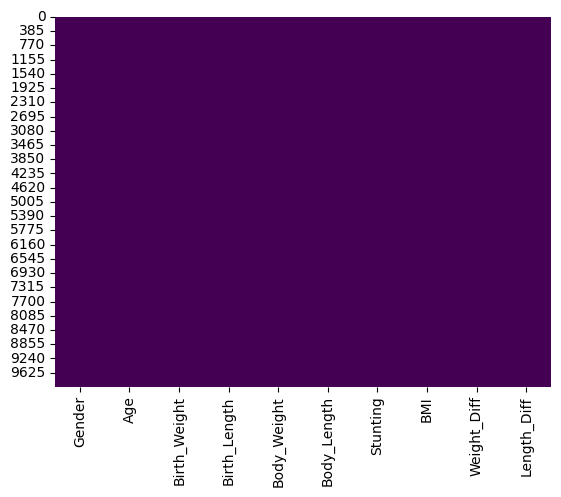

In [49]:
print(df.isnull().sum())  # jumlah missing values per kolom
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [50]:
print(df.describe())  # statistik deskriptif

                Age  Birth_Weight  Birth_Length   Body_Weight  Body_Length  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000   
mean      14.255000      2.757600     49.117400      7.631990     68.85492   
std        7.923285      0.291092      0.439814      1.720461      8.90664   
min        6.000000      2.000000     48.000000      2.900000     49.00000   
25%       10.000000      2.800000     49.000000      6.400000     65.00000   
50%       13.000000      2.800000     49.000000      7.700000     68.30000   
75%       15.000000      2.900000     49.000000      9.000000     72.20000   
max       48.000000      3.100000     50.000000     10.500000     92.70000   

                BMI   Weight_Diff   Length_Diff  
count  10000.000000  10000.000000  10000.000000  
mean       0.001697      4.874390     19.737520  
std        0.000630      1.726503      8.928912  
min        0.000337     -0.200000     -1.000000  
25%        0.001362      4.100000     16.000000

In [51]:
# Initialize encoders and scaler
le = LabelEncoder()
scaler = MinMaxScaler()

# Convert categorical/boolean columns to numeric
df['Stunting'] = le.fit_transform(df['Stunting'])
df['Gender'] = le.fit_transform(df['Gender'])

# Define numeric features with the correct column names
numeric_features = ['Age', 'Birth_Weight', 'Birth_Length', 'Body_Weight', 'Body_Length', 'BMI', 'Weight_Diff', 'Length_Diff']

# Verify columns exist
print("\nAvailable columns after renaming:", df.columns.tolist())

# Scale numeric features
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df


Available columns after renaming: ['Gender', 'Age', 'Birth_Weight', 'Birth_Length', 'Body_Weight', 'Body_Length', 'Stunting', 'BMI', 'Weight_Diff', 'Length_Diff']


,Gender,Age,Birth_Weight,Birth_Length,Body_Weight,Body_Length,Stunting,BMI,Weight_Diff,Length_Diff
0,1,0.261905,0.909091,0.5,0.934211,0.530892,0,0.391720,0.827586,0.529540
1,0,0.119048,0.818182,0.5,0.000000,0.366133,1,0.086458,0.022989,0.371991
2,1,0.238095,0.818182,0.5,0.736842,0.530892,1,0.320419,0.666667,0.529540
3,1,0.595238,0.727273,0.5,0.460526,0.320366,1,0.315936,0.436782,0.328228
4,1,0.214286,1.000000,0.5,1.000000,0.000000,1,1.000000,0.873563,0.021882
...,...,...,...,...,...,...,...,...,...,...
9995,1,0.214286,0.909091,0.5,0.802632,0.320366,1,0.478256,0.712644,0.328228
9996,0,0.142857,0.727273,0.0,0.631579,0.320366,0,0.397096,0.586207,0.350109
9997,1,0.238095,0.727273,0.5,0.631579,0.000000,0,0.711034,0.586207,0.021882
9998,1,0.190476,0.727273,0.5,0.934211,0.457666,1,0.436832,0.850575,0.459519


In [52]:
# 2. Pisahkan Fitur dan Target
X = df.drop(columns=['Stunting'])  # 'Stunting' adalah target
y = df['Stunting']

# 3. Terapkan SMOTE
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X, y)

# 4. Gabungkan Kembali Hasil SMOTE
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [53]:
# Pisahkan data berdasarkan nilai Gender
data_male = data_resampled[data_resampled['Gender'] == 1]  # Male
data_female = data_resampled[data_resampled['Gender'] == 0]  # Female

# Hitung jumlah data yang perlu ditambahkan agar seimbang
difference = abs(len(data_male) - len(data_female))

if len(data_male) < len(data_female):
    # Oversampling Male jika jumlah Male lebih sedikit
    data_male_oversampled = data_male.sample(n=difference, replace=True, random_state=42)
    data_balanced = pd.concat([data_resampled, data_male_oversampled], axis=0)
else:
    # Oversampling Female jika jumlah Female lebih sedikit
    data_female_oversampled = data_female.sample(n=difference, replace=True, random_state=42)
    data_balanced = pd.concat([data_resampled, data_female_oversampled], axis=0)

# Acak kembali data setelah oversampling
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [54]:
data_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21616 entries, 0 to 21615
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        21616 non-null  int64  
 1   Age           21616 non-null  float64
 2   Birth_Weight  21616 non-null  float64
 3   Birth_Length  21616 non-null  float64
 4   Body_Weight   21616 non-null  float64
 5   Body_Length   21616 non-null  float64
 6   BMI           21616 non-null  float64
 7   Weight_Diff   21616 non-null  float64
 8   Length_Diff   21616 non-null  float64
 9   Stunting      21616 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.6 MB


Gender          0
Age             0
Birth_Weight    0
Birth_Length    0
Body_Weight     0
Body_Length     0
BMI             0
Weight_Diff     0
Length_Diff     0
Stunting        0
dtype: int64


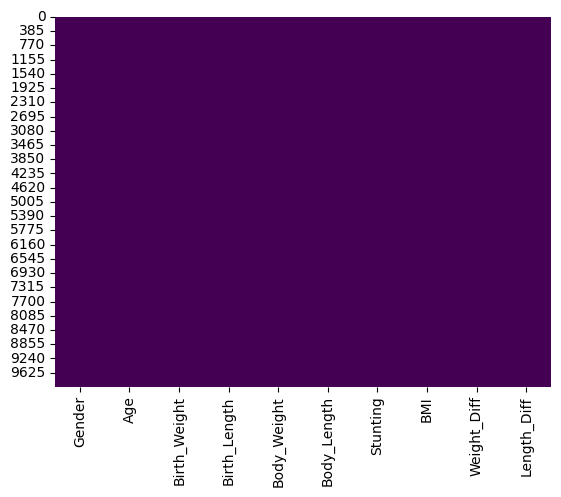

In [55]:
print(data_balanced.isnull().sum())  # jumlah missing values per kolom
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [56]:
data_balanced

,Gender,Age,Birth_Weight,Birth_Length,Body_Weight,Body_Length,BMI,Weight_Diff,Length_Diff,Stunting
0,1,0.976190,0.818182,0.5,0.000000,0.457666,0.067310,0.022989,0.459519,1
1,0,0.166667,0.909091,0.5,0.671053,0.530892,0.296652,0.597701,0.529540,1
2,1,0.166667,0.909091,0.5,0.434211,0.320366,0.303450,0.390805,0.328228,1
3,1,0.095238,0.818182,1.0,0.736842,0.457666,0.358764,0.666667,0.437637,1
4,0,0.309524,0.000000,0.5,0.565789,0.457666,0.291105,0.620690,0.459519,1
...,...,...,...,...,...,...,...,...,...,...
21611,1,0.086582,1.000000,1.0,0.460526,0.441648,0.256331,0.402299,0.422319,0
21612,0,0.142857,0.909091,0.5,0.671053,0.503432,0.309615,0.597701,0.503282,1
21613,1,0.833333,0.909091,0.5,0.552632,0.530892,0.253871,0.494253,0.529540,1
21614,1,0.142857,0.727273,1.0,0.631579,0.617849,0.246705,0.586207,0.590810,0


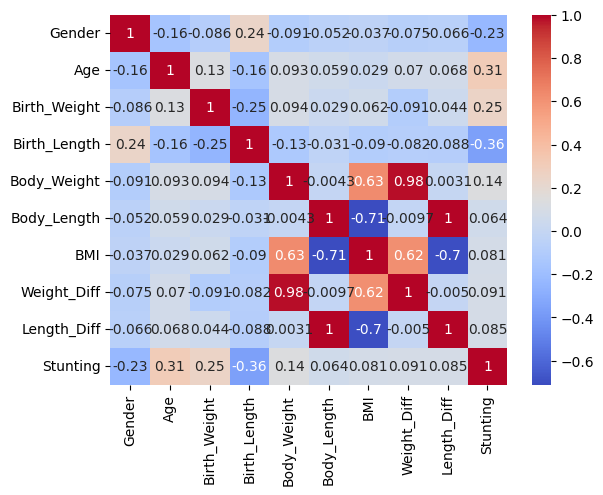

In [57]:
sns.heatmap(data_balanced.corr(), annot=True, cmap='coolwarm')
plt.show()

In [58]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_balanced, test_size=0.2, random_state=42)

In [59]:
label = "Stunting"

# Konversi dataframe pandas ke tf.data.Dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)


In [60]:
# # Model GBT
# model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION,hyperparameter_template="benchmark_rank1")

# # Latih model
# model.fit(train_ds)

# # Create a Random Search tuner with 50 trials and automatic hp configuration.
# tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# # Define and train the model.
# tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
# tuned_model.fit(train_ds, verbose=2)

# Set hyperparameter
# Set hyperparameter dengan float pada density factor
model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    split_axis="SPARSE_OBLIQUE",
    sparse_oblique_projection_density_factor=3.0,  # Ubah ke float
    sparse_oblique_normalization="NONE",
    sparse_oblique_weights="BINARY",
    categorical_algorithm="RANDOM",
    growing_strategy="LOCAL",
    max_depth=8,
    sampling_method="RANDOM",
    subsample=1.0,
    shrinkage=0.1,
    min_examples=5,
    use_hessian_gain=False,
    num_candidate_attributes_ratio=0.5
)

# Latih model
model.fit(train_ds)

# # Model GBT
# model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# # Latih model
# model.fit(train_ds)

# # Model GBT
# model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)

# # Latih model
# model.fit(train_ds)



Use /tmp/tmp_rjdf0yc as temporary training directory
Reading training dataset...


2024-11-13 06:20:51.981071: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-11-13 06:20:51.981213: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-11-13 06:20:51.981222: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.498497. Found 17292 examples.
Training model...


I0000 00:00:1731453652.573821  106011 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1731453652.574815  106011 kernel.cc:783] Collect training examples
I0000 00:00:1731453652.574827  106011 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1731453652.576775  106011 kernel.cc:401] Number of batches: 18
I0000 00:00:1731453652.576786  106011 kernel.cc:402] Number of examples: 17292
I0000 00:00:1731453652.578411  106011 kernel.cc:802] Training dataset:
Number of records: 17292
Number of columns: 10

Number of columns by type:
	NUMERICAL: 9 (90%)
	CATEGORICAL: 1 (10%)

Columns:

NUMERICAL: 9 (90%)
	0: "Age" NUMERICAL mean:0.17978 min:0 m

Model trained in 0:00:18.158820
Compiling model...


I0000 00:00:1731453670.570804  124912 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.433606
2024-11-13 06:21:10.570845: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 219
2024-11-13 06:21:10.603900: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 190 tree(s) i.e. 190  iteration(s).
2024-11-13 06:21:10.604604: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:190 valid-loss:0.433606 valid-accuracy:0.912404
I0000 00:00:1731453670.611144  124912 kernel.cc:926] Export model in log directory: /tmp/tmp_rjdf0yc with prefix 5e3f839d5c0a418a
I0000 00:00:1731453670.629172  124912 kernel.cc:944] Save model in resources
I0000 00:00:1731453670.631752  106011 abstract_

Model compiled.


In [61]:
# model.compile(metrics=["accuracy"])
# evaluation = model.evaluate(test_ds, return_dict=True)
# print()

# for name, value in evaluation.items():
#   print(f"{name}: {value:.4f}")

# Evaluate the model
model.compile(["accuracy"])
test_accuracy = model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy : {test_accuracy:.4f}")

Test accuracy : 0.9235


In [62]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

In [63]:
model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.912404477596283, loss=0.43360635638237, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

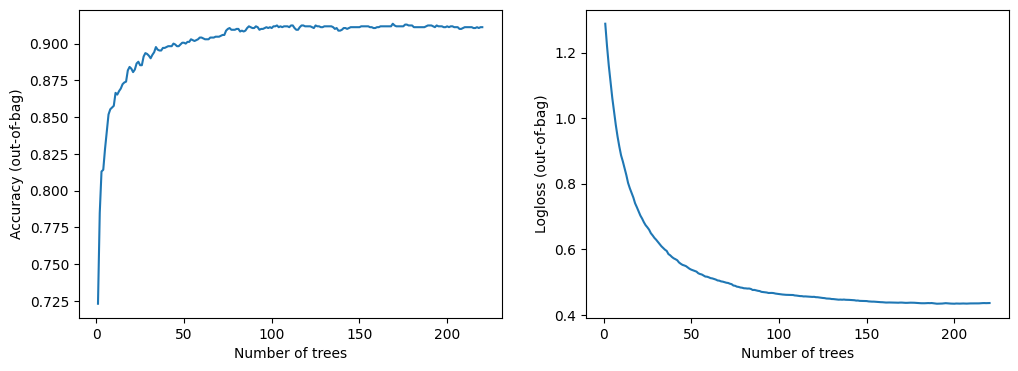

In [64]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [65]:
# Evaluasi model menggunakan data uji
evaluation = model.evaluate(test_ds)
print(evaluation)

5/5 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.9235
[0.0, 0.9234505295753479]


In [66]:
feature_importance = model.make_inspector().variable_importances()
print(feature_importance)

{'INV_MEAN_MIN_DEPTH': [("Age" (1; #0), 0.550591460510003), ("BMI" (1; #1), 0.1866722808086164), ("Birth_Length" (1; #2), 0.1687192594452039), ("Birth_Weight" (1; #3), 0.16630464538054798), ("Body_Length" (1; #4), 0.15264985226115257), ("Body_Weight" (1; #5), 0.15027185434653018), ("Length_Diff" (1; #7), 0.13434948716816122), ("Gender" (1; #6), 0.13357194800193348), ("Weight_Diff" (1; #8), 0.13265936887938978)], 'SUM_SCORE': [("Age" (1; #0), 8507.218371478522), ("Birth_Length" (1; #2), 3652.719445389461), ("BMI" (1; #1), 2480.4498744078096), ("Birth_Weight" (1; #3), 1455.2127606648924), ("Body_Length" (1; #4), 961.1492543789179), ("Body_Weight" (1; #5), 893.2566928547774), ("Length_Diff" (1; #7), 207.75892237875348), ("Weight_Diff" (1; #8), 118.97049719563802), ("Gender" (1; #6), 73.79522742135077)], 'NUM_AS_ROOT': [("Age" (1; #0), 123.0), ("Birth_Weight" (1; #3), 18.0), ("Birth_Length" (1; #2), 14.0), ("BMI" (1; #1), 12.0), ("Body_Weight" (1; #5), 12.0), ("Body_Length" (1; #4), 10.0),

In [67]:
# Generate predictions
predictions = model.predict(test_ds)

# Hitung jumlah prediksi yang nilainya di bawah 0.5
below_threshold_count = np.sum(predictions < 0.5)

print(f"Jumlah prediksi di bawah 0.5: {below_threshold_count}")


5/5 [==============================] - 0s 17ms/step
Jumlah prediksi di bawah 0.5: 1971


In [68]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [70]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/assets/5e3f839d5c0a418adone (stored 0%)
  adding: model/assets/5e3f839d5c0a418agradient_boosted_trees_header.pb (deflated 77%)
  adding: model/assets/5e3f839d5c0a418anodes-00000-of-00001 (deflated 55%)
  adding: model/assets/5e3f839d5c0a418adata_spec.pb (deflated 34%)
  adding: model/assets/5e3f839d5c0a418aheader.pb (deflated 29%)
  adding: model/fingerprint.pb (stored 0%)
  adding: model/saved_model.pb (deflated 86%)
  adding: model/keras_metadata.pb (deflated 82%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 46%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 59%)


In [72]:
# Mengonversi model SavedModel ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('model')

# Tell the converter to use the TensorFlow Decision Forests converter.
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
# Allow custom ops
converter.allow_custom_ops = True

# Rest of your conversion code
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2024-11-13 06:26:24.576375: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path model/assets/ with prefix 5e3f839d5c0a418a
I0000 00:00:1731453984.644973  107020 decision_forest.cc:761] Model loaded with 190 root(s), 28854 node(s), and 9 input feature(s).
I0000 00:00:1731453984.645007  107020 abstract_model.cc:1404] Engine "GradientBoostedTreesGeneric" built
2024-11-13 06:26:24.645019: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine
2024-11-13 06:26:24.732784: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path model/assets/ with prefix 5e3f839d5c0a418a
I0000 00:00:1731453984.798856  107020 decision_forest.cc:761] Model loaded with 190 root(s), 28854 node(s), and 9 input feature(s).
2024-11-13 06:26:24.798898: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine
W0000 00:00:1731453985.076777  106011 tf_tfl_flatbuff

In [31]:
#contoh prediksi


In [73]:
# nilai minimum dan maksimum dari data training
min_age = 0  # nilai min untuk kolom Age
max_age = 1  # nilai max untuk kolom Age
min_birth_weight = 0  # nilai min untuk kolom Birth_Weight
max_birth_weight = 1  # nilai max untuk kolom Birth_Weight
min_birth_length = 0  # nilai min untuk kolom Birth_Length
max_birth_length = 1  # nilai max untuk kolom Birth_Length
min_body_weight = 0  # nilai min untuk kolom Body_Weight
max_body_weight = 1  # nilai max untuk kolom Body_Weight
min_body_length = 0  # nilai min untuk kolom Body_Length
max_body_length = 1  # nilai max untuk kolom Body_Length


# Misalnya kita punya data scaler dari proses training, yang bisa berupa nilai min dan max tiap kolom
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

# Data baru
data_baru = {
    "Gender": 0,  # Male
    "Age": normalize(8, min_age, max_age),  # Normalisasi dengan nilai age range dari training
    "Birth_Weight": normalize(2.7, min_birth_weight, max_birth_weight),
    "Birth_Length": normalize(49, min_birth_length, max_birth_length),
    "Body_Weight": normalize(2.9, min_body_weight, max_body_weight),
    "Body_Length": normalize(73.5, min_body_length, max_body_length)
}

# Menghitung BMI
data_baru["BMI"] = data_baru["Body_Weight"] / ((data_baru["Body_Length"]/100) ** 2)

# Menghitung Weight_Diff dan Length_Diff
data_baru["Weight_Diff"] = data_baru["Body_Weight"] - data_baru["Birth_Weight"]
data_baru["Length_Diff"] = data_baru["Body_Length"] - data_baru["Birth_Length"]

# Membuat DataFrame
df = pd.DataFrame([data_baru])

df.head()

# Mengonversi DataFrame menjadi tf.data.Dataset
dataset = tfdf.keras.pd_dataframe_to_tf_dataset(df, task=tfdf.keras.Task.CLASSIFICATION)

# Melakukan prediksi menggunakan model
prediction = model.predict(dataset)

print(prediction)

# Ambil hasil prediksi, misalnya jika lebih dari 0.5 kita kategorikan sebagai tidak stunting (1)
stunting_prediction = int(prediction[0] > 0.5)  # Jika output lebih dari 0.5, kita kategorikan sebagai tidak stunting (1)
print("Prediksi Stunting:", "tidak stunting" if stunting_prediction == 1 else "stunting")



1/1 [==============================] - 0s 27ms/step
[[0.8724391]]
Prediksi Stunting: tidak stunting


/tmp/ipykernel_106011/2774513968.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stunting_prediction = int(prediction[0] > 0.5)  # Jika output lebih dari 0.5, kita kategorikan sebagai tidak stunting (1)


In [36]:
# Memuat model SavedModel
new_model = tf.saved_model.load('test-tf-df-manual-tuner')

# Jika ingin memeriksa arsitektur model
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	Age
	BMI
	Birth_Length
	Birth_Weight
	Body_Length
	Body_Weight
	Gender
	Length_Diff
	Weight_Diff

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.          "Age"  0.529371 ################
    2.          "BMI"  0.179189 #
    3. "Birth_Length"  0.173243 #
    4. "Birth_Weight"  0.165952 #
    5.  "Body_Length"  0.154174 
    6.  "Body_Weight"  0.148601 
    7.  "Length_Diff"  0.134264 
    8.       "Gender"  0.132830 
    9.  "Weight_Diff"  0.132378 

Variable Importance: NUM_AS_ROOT:
    1.          "Age" 97.000000 ################
    2. "Birth_Length" 17.0

2024-11-13 05:00:07.745679: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path test-tf-df-manual-tuner/assets/ with prefix c2b733333dd147a7
I0000 00:00:1731448807.801062  107026 decision_forest.cc:761] Model loaded with 154 root(s), 23994 node(s), and 9 input feature(s).
I0000 00:00:1731448807.801095  107026 abstract_model.cc:1404] Engine "GradientBoostedTreesGeneric" built
2024-11-13 05:00:07.801107: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine
